138.867167
Epoch 1/300
4/4 [==============================] - 1s 46ms/step - loss: 0.8878 - val_loss: 1.5821
Epoch 2/300
4/4 [==============================] - 0s 12ms/step - loss: 0.8665 - val_loss: 1.5793
Epoch 3/300
4/4 [==============================] - 0s 12ms/step - loss: 0.8532 - val_loss: 1.5800
Epoch 4/300
4/4 [==============================] - 0s 12ms/step - loss: 0.8461 - val_loss: 1.5819
Epoch 5/300
4/4 [==============================] - 0s 12ms/step - loss: 0.8409 - val_loss: 1.5861
Epoch 6/300
4/4 [==============================] - 0s 19ms/step - loss: 0.8354 - val_loss: 1.5911
Epoch 7/300
4/4 [==============================] - 0s 14ms/step - loss: 0.8307 - val_loss: 1.5916
Epoch 8/300
4/4 [==============================] - 0s 11ms/step - loss: 0.8270 - val_loss: 1.5889
Epoch 9/300
4/4 [==============================] - 0s 11ms/step - loss: 0.8236 - val_loss: 1.5876
Epoch 10/300
4/4 [==============================] - 0s 12ms/step - loss: 0.8203 - val_loss: 1.5887
Epoch 11

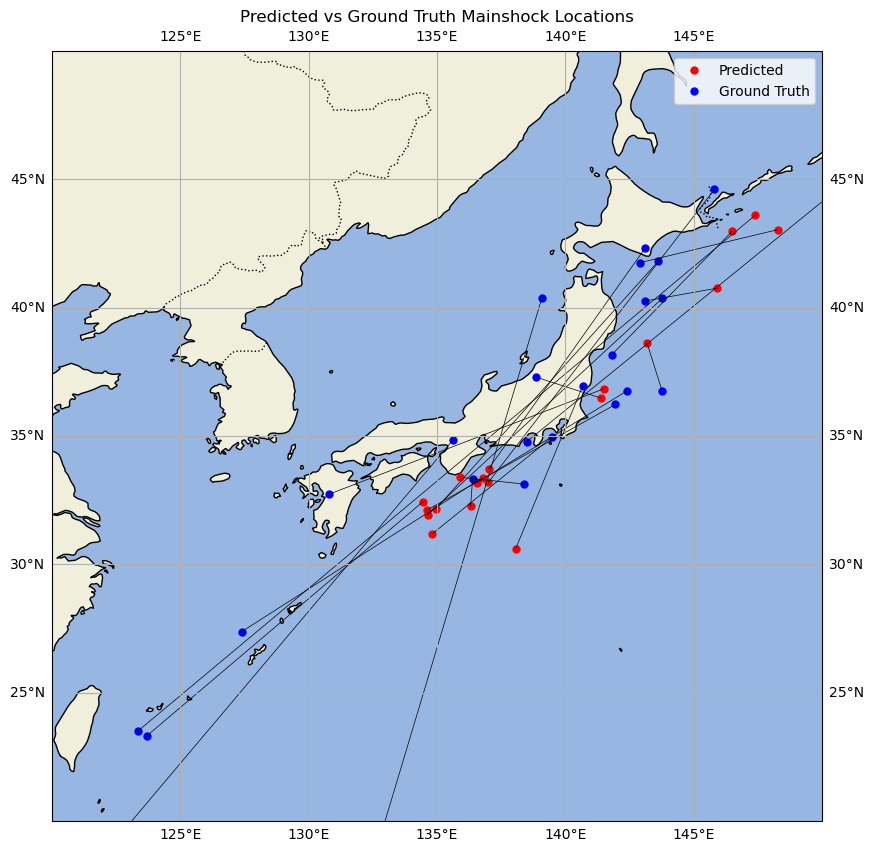

learning_rate =  0.0001 epochs =  300 batch_size =  20 mse =  128.47204448708638


In [7]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd




def plot_predictions(y_pred, y_true):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot predicted points
    ax.plot(y_pred[:, 1], y_pred[:, 0], 'ro', markersize=5, transform=ccrs.PlateCarree(), label='Predicted')

    # Plot ground truth points
    ax.plot(y_true[:, 1], y_true[:, 0], 'bo', markersize=5, transform=ccrs.PlateCarree(), label='Ground Truth')

    # Draw lines connecting predicted and ground truth points
    for pred, true in zip(y_pred, y_true):
        ax.plot([pred[1], true[1]], [pred[0], true[0]], 'k-', linewidth=0.5, transform=ccrs.PlateCarree())

    # Set the map extent to focus on Japan
    ax.set_extent([120, 150, 20, 50], crs=ccrs.PlateCarree())

    # Add gridlines
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.title('Predicted vs Ground Truth Mainshock Locations')
    plt.legend()
    
    # Save the figure
    plt.savefig('mainshock_predictions_map.png', dpi=300, bbox_inches='tight')
    plt.show()


# Load data from HDF5 file
def load_data(file_path):
    X = []
    y = []
    max_length = 0
    with h5py.File(file_path, 'r') as f:
        for id_seq in f.keys():
            group = f[id_seq]
            displacements = group['gps_stations_displacements'][()]
            main_shock_location = group.attrs['main_shock_location']
            
            # Flatten the displacements for each sequence
            flat_displacements = displacements.reshape(-1)

            if len(flat_displacements) > 50:
                X.append(flat_displacements)
                y.append(main_shock_location)
                if len(flat_displacements) > max_length:
                    max_length = len(flat_displacements)

    # Pad all sequences to have the same length
    X_padded = np.array([np.pad(x, (0, max_length - len(x)), 'constant', constant_values=0) for x in X])
    return X_padded, np.array(y)


# Preprocess data
def preprocess_data(X, y):
    # Pad sequences to have the same length
    max_length = max(len(x) for x in X)
    X_padded = np.array([np.pad(x, (0, max_length - len(x))) for x in X])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_y

# Build and train model
def build_and_train_model(X_train, y_train, learning_rate = 0.00001, epochs = 300, batch_size = 80, validation_split = 0.2, verbose = 1):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(2)  # Output layer for latitude and longitude
    ])
    
    model.compile(optimizer=Adam(learning_rate= learning_rate), loss='mse')
    model.fit(X_train, y_train, epochs= epochs, batch_size= batch_size, validation_split= validation_split, verbose= verbose)
    
    return model

# Predict and evaluate
def predict_and_evaluate(model, X_test, y_test, scaler_y):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)
    tmp = y_pred - y_true
    tmp[0] = tmp[0]/30
    tmp[1] = tmp[1]/70
    mse = np.mean(tmp**2)
    print(f"Mean Squared Error: {mse}")
    
    return y_pred, y_true, mse

# Main function
def main(learning_rate = 0.00001, epochs = 300, batch_size = 80):
    file_path = "Data/Displacements_min_mainshock_mag=6_min_stations_per_main_shock=3_min_after_shock_mag=4_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1_min_days_between_mainshocks=30_grid_size_km=250.hdf5"
    
    X, y = load_data(file_path)
    print(y[0][1])
    X_train, X_test, y_train, y_test, scaler_y = preprocess_data(X, y)
    
    model = build_and_train_model(X_train, y_train, learning_rate = learning_rate, epochs = epochs, batch_size = batch_size)
    
    y_pred, y_true, mse = predict_and_evaluate(model, X_test, y_test, scaler_y)
    
    # Print some predictions vs true values
    #for i in range(5):
       # print(f"Predicted: {y_pred[i]}, True: {y_true[i]}")

    plot_predictions(y_pred, y_true)

    print ("learning_rate = ", learning_rate, "epochs = ", epochs, "batch_size = ", batch_size, "mse = ", mse)

    return mse



if __name__ == "__main__":

    #df = pd.DataFrame(columns = ['learning_rate', 'epochs', 'batch_size', 'mse'])
    #for lr in [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    #    for e in [100, 200, 300, 400, 500]:
    #        for bs in [10, 20, 40, 80, 160]:
    #            mse = main(lr, e, bs)
    #            new_row = pd.DataFrame({'learning_rate': [lr], 'epochs': [e], 'batch_size': [bs], 'mse': [mse]})
    #            df = pd.concat([df, new_row], ignore_index=True)
    #df.to_csv('results.csv')

    mse = main(0.0001, 300, 20)

